# Apply CNN Classifier to DESI Spectra and visualize results with gradCAM

Mini-SV2 tiles from February-March 2020:
- https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2

See also the DESI tile picker with (limited) SV0 tiles from March 2020:
- https://desi.lbl.gov/svn/data/tiles/trunk/
- https://desi.lbl.gov/svn/data/tiles/trunk/SV0.html

In [1]:
import sys
sys.path.append('/global/homes/p/portmanm/timedomain/desitrip/py/')
sys.path.append('/global/homes/p/portmanm/desi/desispec/')

from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra
from desispec.coaddition import coadd_cameras

from desitarget.cmx.cmx_targetmask import cmx_mask

from desitrip.preproc import rebin_flux, rescale_flux
from desitrip.deltamag import delta_mag

from astropy.io import fits
from astropy.table import Table, vstack, hstack

from glob import glob
from datetime import date

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras

In [2]:
mpl.rc('font', size=14)

In [3]:
# Set up BGS target bit selection.
cmx_bgs_bits = '|'.join([_ for _ in cmx_mask.names() if 'BGS' in _])

## Select a Date & Tile from the Tile Picker

In [10]:
tile_ids = []
obsdates = []
petal_ids = []
rows = []

with open('cnn_feed.txt') as tfile:
    all_lines = tfile.readlines()
    
for line_idx in range(len(all_lines)):
    line = all_lines[line_idx].split(',') # Get rid of spacing between
    #print(line)
    tile_ids.append(line[0])
    obsdates.append(line[1].strip())
    petal_ids.append(line[2].strip())
    rows.append(line[-1].strip(' \n'))

In [46]:
# Temp version... until I fix may 3 thing
tile_ids = []
obsdates = []
petal_ids = []
rows = []

with open('cnn_feed.txt') as tfile:
    all_lines = tfile.readlines()
    
for line_idx in range(len(all_lines)):
    line = all_lines[line_idx].split(',') # Get rid of spacing between
    #print(line)
    #if line[1].strip() < '20210503': for before adjusting coadd/zbest grab for 5/3 change
    tile_ids.append(line[0])
    obsdates.append(line[1].strip())
    petal_ids.append(line[2].strip())
    rows.append(line[-1].strip(' \n'))

In [47]:
# Access redux folder.
zbfiles = []
cafiles = []
#print(rows)
# After May 3, format changed, look at Antonella's implementation 
# if int(obsdate)<20210503:
#             prefix_in = '/'.join([redux, 'tiles', tile_number, obsdate])
#         else:
#             prefix_in = '/'.join([redux, 'tiles/cumulative', tile_number])

redux='/global/project/projectdirs/desi/spectro/redux/daily/tiles'
for tile_id, obsdate, petal_id, row in zip(tile_ids[:], obsdates[:], petal_ids[:], rows[:]):
    if obsdate < '20210503':
        prefix_in ='/'.join([redux, str(tile_id), str(obsdate)])
    else:
        prefix_in = '/'.join([redux, 'cumulative', str(tile_id)])
        
    if not os.path.isdir(prefix_in):
        print('{} does not exist.'.format(prefix_in))
        tile_ids.remove(tile_id)
        obsdates.remove(obsdate)
        petal_ids.remove(petal_id)
        rows.remove(row)
        continue
        
# Also check something around here (previously line 298)
#              if int(obsdate)<20210503:
#                 zbfiles = sorted(glob('{}/zbest*.fits'.format(prefix_in)))
#                 cafiles = sorted(glob('{}/coadd*.fits'.format(prefix_in)))
#             else:
#                 zbfiles = sorted(glob('{}/*/zbest*.fits'.format(prefix_in)))
#                 cafiles = sorted(glob('{}/*/spectra*.fits'.format(prefix_in)))
#                 #cafiles = sorted(glob('{}/cframe*.fits'.format(prefix_in)))

# Also this previously on line 325
#if int(obsdate)>20210503:
#                     select_nite = pspectra.fibermap['NIGHT'] == int(obsdate)
#                     pspectra = pspectra[select_nite]

    # List zbest and coadd files.
    # Data are stored by petal ID.
    fileend = '-'.join((petal_id, tile_id, obsdate))
    #print(fileend)
    zbfiles.extend(sorted(glob('{}/zbest-'.format(prefix_in) + fileend + '*.fits')))
    cafiles.extend(sorted(glob('{}/coadd-'.format(prefix_in) + fileend + '*.fits')))

In [48]:
# zbest files from redrock.
zbfiles
print(len(zbfiles))
print(len(cafiles))
print(len(tile_ids))
print(len(obsdates))
print(len(petal_ids))
print(len(rows))

138
138
138
138
138
138


In [80]:
# Co-added spectra from multiple exposures + the three spectrograph arms.
cafiles

['/global/project/projectdirs/desi/spectro/redux/daily/tiles/80662/20210221/coadd-3-80662-20210221.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/80662/20210322/coadd-3-80662-20210322.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/228/20210405/coadd-5-228-20210405.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/217/20210406/coadd-3-217-20210406.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/28/20210407/coadd-6-28-20210407.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/246/20210408/coadd-8-246-20210408.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/219/20210409/coadd-3-219-20210409.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/228/20210410/coadd-2-228-20210410.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/221/20210412/coadd-4-221-20210412.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/283/20210413/co

## Load the Keras Model

Load a model trained on real or simulated data using the native Keras output format. In the future this could be updated to just load the Keras weights.

In [49]:
tfmodel = '/global/homes/l/lehsani/timedomain/desitrip/docs/nb/models_9label_first/6_b65_e200_9label/b65_e200_9label_model'
#tfmodel = '/global/homes/s/sybenzvi/desi/timedomain/desitrip/docs/nb/6label_cnn_restframe'
if os.path.exists(tfmodel):
    classifier = keras.models.load_model(tfmodel)
else:
    classifier = None
    print('Sorry, could not find {}'.format(tfmodel))

In [50]:
if classifier is not None:
    classifier.summary()

Model: "SNnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Spec (InputLayer)      [(None, 150, 1)]          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 150, 8)            48        
_________________________________________________________________
batch_normalization_20 (Batc (None, 150, 8)            32        
_________________________________________________________________
activation_20 (Activation)   (None, 150, 8)            0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 75, 8)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 75, 16)            656       
_________________________________________________________________
batch_normalization_21 (Batc (None, 75, 16)            64    

## Loop Through Spectra and Classify

In [51]:
# Loop through zbest and coadd files for each petal.
# Extract the fibermaps, ZBEST tables, and spectra.
# Keep only BGS targets passing basic event selection.
allzbest = None
allfmap = None
allwave = None
allflux = None
allivar = None
allmask = None
allres  = None
handy_table = []

color_string = 'brz'
count = 0

for cafile, zbfile, row in zip(cafiles, zbfiles, rows): # rows[:-1] IS TEMPORARY
    # Access data per petal.
    zbest = Table.read(zbfile, 'ZBEST')
    #print(zbest.colnames)
    #fibermap = Table.read(zbfile, 'FIBERMAP')
    targetid = zbest[int(row)]['TARGETID']
    chi2 = zbest[int(row)]['CHI2']
    if targetid < 0:
        print("Negative targetids don't play nice... skipping.")
        continue
    print(targetid)
    
    pspectra = read_spectra(cafile)
    cspectra = coadd_cameras(pspectra)
    fibermap = cspectra.fibermap
    ra = fibermap[int(row)]['TARGET_RA']
    dec = fibermap[int(row)]['TARGET_DEC']
    handy_table.append((targetid, ra, dec, tile_ids[count], obsdates[count], row))
    #print(pspectra.flux)S

    # Apply standard event selection.
    #isTGT = fibermap['OBJTYPE'] == 'TGT'
    #isGAL = zbest['SPECTYPE'] == 'GALAXY'
    
    #This is old selection, does not work anymore! BGS target is always 0
    #isBGS = fibermap['SV1_BGS_TARGET'] & bgs_mask.mask(sv1_bgs_bits) != 0
    #isBGS = bgs_mask.mask(bgs_bits) != 0
    #isGoodFiber = fibermap['FIBERSTATUS'] == 0
    #isGoodZbest = (zbest['DELTACHI2'] > 25.) & (zbest['ZWARN'] == 0)
    #select = isTGT & isGAL #& isBGS & isGoodFiber & isGoodZbest
    #fibermap = delta_mag(cspectra, fibermap, select, nsigma=3)
    #isBGS = fibermap['CMX_TARGET'] & cmx_mask.mask(cmx_bgs_bits) != 0
    select = fibermap['TARGETID'] == targetid #isTGT & isGAL #& isBGS
    #exp_id = fibermap['EXPID'] & select # first need to figure out all columns as this fails
    #print(select)
    count += 1

    # Accumulate spectrum data.
    if allzbest is None:
        allzbest = zbest[select]
        allfmap = fibermap[select]
        allwave = cspectra.wave[color_string]
        allflux = cspectra.flux[color_string][select]
        allivar = cspectra.ivar[color_string][select]
        allmask = cspectra.mask[color_string][select]
        allres  = cspectra.resolution_data[color_string][select]
    else:
        allzbest = vstack([allzbest, zbest[select]])
        allfmap = vstack([allfmap, fibermap[select]])
        allflux = np.vstack([allflux, cspectra.flux[color_string][select]])
        allivar = np.vstack([allivar, cspectra.ivar[color_string][select]])
        allmask = np.vstack([allmask, cspectra.mask[color_string][select]])
        allres  = np.vstack([allres, cspectra.resolution_data[color_string][select]])

616088540027028545
INFO:spectra.py:253:read_spectra: iotime 0.553 sec to read coadd-3-80662-20210221.fits at 2021-06-06T23:41:39.700251


INFO:desiutil.log.dlm58.info:iotime 0.553 sec to read coadd-3-80662-20210221.fits at 2021-06-06T23:41:39.700251


39627787761355419
INFO:spectra.py:253:read_spectra: iotime 0.609 sec to read coadd-7-80662-20210221.fits at 2021-06-06T23:41:48.131992


INFO:desiutil.log.dlm58.info:iotime 0.609 sec to read coadd-7-80662-20210221.fits at 2021-06-06T23:41:48.131992


39627769650354141
INFO:spectra.py:253:read_spectra: iotime 0.562 sec to read coadd-8-80662-20210221.fits at 2021-06-06T23:41:56.023947


INFO:desiutil.log.dlm58.info:iotime 0.562 sec to read coadd-8-80662-20210221.fits at 2021-06-06T23:41:56.023947


39627793780183579
INFO:spectra.py:253:read_spectra: iotime 0.555 sec to read coadd-4-80662-20210221.fits at 2021-06-06T23:42:04.349633


INFO:desiutil.log.dlm58.info:iotime 0.555 sec to read coadd-4-80662-20210221.fits at 2021-06-06T23:42:04.349633


39627896934895528
INFO:spectra.py:253:read_spectra: iotime 0.492 sec to read coadd-8-136-20210405.fits at 2021-06-06T23:42:11.719699


INFO:desiutil.log.dlm58.info:iotime 0.492 sec to read coadd-8-136-20210405.fits at 2021-06-06T23:42:11.719699


39627817981317571
INFO:spectra.py:253:read_spectra: iotime 0.595 sec to read coadd-4-66-20210405.fits at 2021-06-06T23:42:20.511616


INFO:desiutil.log.dlm58.info:iotime 0.595 sec to read coadd-4-66-20210405.fits at 2021-06-06T23:42:20.511616


39627811979264260
INFO:spectra.py:253:read_spectra: iotime 0.604 sec to read coadd-7-66-20210405.fits at 2021-06-06T23:42:29.233347


INFO:desiutil.log.dlm58.info:iotime 0.604 sec to read coadd-7-66-20210405.fits at 2021-06-06T23:42:29.233347


39627775698537653
INFO:spectra.py:253:read_spectra: iotime 0.688 sec to read coadd-2-66-20210405.fits at 2021-06-06T23:42:37.688027


INFO:desiutil.log.dlm58.info:iotime 0.688 sec to read coadd-2-66-20210405.fits at 2021-06-06T23:42:37.688027


39627776273156346
INFO:spectra.py:253:read_spectra: iotime 0.560 sec to read coadd-2-228-20210405.fits at 2021-06-06T23:42:46.193144


INFO:desiutil.log.dlm58.info:iotime 0.560 sec to read coadd-2-228-20210405.fits at 2021-06-06T23:42:46.193144


39627806488921652
INFO:spectra.py:253:read_spectra: iotime 0.588 sec to read coadd-6-228-20210405.fits at 2021-06-06T23:42:54.816842


INFO:desiutil.log.dlm58.info:iotime 0.588 sec to read coadd-6-228-20210405.fits at 2021-06-06T23:42:54.816842


39627782308759050
INFO:spectra.py:253:read_spectra: iotime 0.553 sec to read coadd-3-228-20210405.fits at 2021-06-06T23:43:03.121487


INFO:desiutil.log.dlm58.info:iotime 0.553 sec to read coadd-3-228-20210405.fits at 2021-06-06T23:43:03.121487


39627794392552723
INFO:spectra.py:253:read_spectra: iotime 0.566 sec to read coadd-5-228-20210405.fits at 2021-06-06T23:43:11.245261


INFO:desiutil.log.dlm58.info:iotime 0.566 sec to read coadd-5-228-20210405.fits at 2021-06-06T23:43:11.245261


39627764197757125
INFO:spectra.py:253:read_spectra: iotime 0.595 sec to read coadd-0-228-20210405.fits at 2021-06-06T23:43:19.889393


INFO:desiutil.log.dlm58.info:iotime 0.595 sec to read coadd-0-228-20210405.fits at 2021-06-06T23:43:19.889393


39627757541396859
INFO:spectra.py:253:read_spectra: iotime 0.523 sec to read coadd-0-39-20210405.fits at 2021-06-06T23:43:28.886472


INFO:desiutil.log.dlm58.info:iotime 0.523 sec to read coadd-0-39-20210405.fits at 2021-06-06T23:43:28.886472


39627811907962460
INFO:spectra.py:253:read_spectra: iotime 0.572 sec to read coadd-6-39-20210405.fits at 2021-06-06T23:43:37.240704


INFO:desiutil.log.dlm58.info:iotime 0.572 sec to read coadd-6-39-20210405.fits at 2021-06-06T23:43:37.240704


39627806480534677
INFO:spectra.py:253:read_spectra: iotime 0.763 sec to read coadd-5-217-20210406.fits at 2021-06-06T23:43:46.064575


INFO:desiutil.log.dlm58.info:iotime 0.763 sec to read coadd-5-217-20210406.fits at 2021-06-06T23:43:46.064575


39627782308760755
INFO:spectra.py:253:read_spectra: iotime 0.698 sec to read coadd-3-217-20210406.fits at 2021-06-06T23:43:55.037984


INFO:desiutil.log.dlm58.info:iotime 0.698 sec to read coadd-3-217-20210406.fits at 2021-06-06T23:43:55.037984


39627770216579660
INFO:spectra.py:253:read_spectra: iotime 0.738 sec to read coadd-2-217-20210406.fits at 2021-06-06T23:44:03.783210


INFO:desiutil.log.dlm58.info:iotime 0.738 sec to read coadd-2-217-20210406.fits at 2021-06-06T23:44:03.783210


39627878832277921
INFO:spectra.py:253:read_spectra: iotime 0.818 sec to read coadd-9-148-20210407.fits at 2021-06-06T23:44:12.823088


INFO:desiutil.log.dlm58.info:iotime 0.818 sec to read coadd-9-148-20210407.fits at 2021-06-06T23:44:12.823088


616088546129740731
INFO:spectra.py:253:read_spectra: iotime 0.754 sec to read coadd-3-56-20210407.fits at 2021-06-06T23:44:21.561269


INFO:desiutil.log.dlm58.info:iotime 0.754 sec to read coadd-3-56-20210407.fits at 2021-06-06T23:44:21.561269


39627805922694984
INFO:spectra.py:253:read_spectra: iotime 0.812 sec to read coadd-6-67-20210407.fits at 2021-06-06T23:44:30.068648


INFO:desiutil.log.dlm58.info:iotime 0.812 sec to read coadd-6-67-20210407.fits at 2021-06-06T23:44:30.068648


Negative targetids don't play nice... skipping.
Negative targetids don't play nice... skipping.
39627781717364320
INFO:spectra.py:253:read_spectra: iotime 0.866 sec to read coadd-8-28-20210407.fits at 2021-06-06T23:44:38.999129


INFO:desiutil.log.dlm58.info:iotime 0.866 sec to read coadd-8-28-20210407.fits at 2021-06-06T23:44:38.999129


39627824604119156
INFO:spectra.py:253:read_spectra: iotime 0.750 sec to read coadd-2-272-20210407.fits at 2021-06-06T23:44:48.374526


INFO:desiutil.log.dlm58.info:iotime 0.750 sec to read coadd-2-272-20210407.fits at 2021-06-06T23:44:48.374526


39627799819980445
INFO:spectra.py:253:read_spectra: iotime 0.859 sec to read coadd-6-40-20210407.fits at 2021-06-06T23:44:57.386924


INFO:desiutil.log.dlm58.info:iotime 0.859 sec to read coadd-6-40-20210407.fits at 2021-06-06T23:44:57.386924


39627787711025554
INFO:spectra.py:253:read_spectra: iotime 0.848 sec to read coadd-3-40-20210407.fits at 2021-06-06T23:45:06.309095


INFO:desiutil.log.dlm58.info:iotime 0.848 sec to read coadd-3-40-20210407.fits at 2021-06-06T23:45:06.309095


39627794434493830
INFO:spectra.py:253:read_spectra: iotime 0.712 sec to read coadd-3-255-20210407.fits at 2021-06-06T23:45:15.313359


INFO:desiutil.log.dlm58.info:iotime 0.712 sec to read coadd-3-255-20210407.fits at 2021-06-06T23:45:15.313359


39627764231311046
INFO:spectra.py:253:read_spectra: iotime 0.780 sec to read coadd-2-255-20210407.fits at 2021-06-06T23:45:23.871637


INFO:desiutil.log.dlm58.info:iotime 0.780 sec to read coadd-2-255-20210407.fits at 2021-06-06T23:45:23.871637


39627800503651302
INFO:spectra.py:253:read_spectra: iotime 0.787 sec to read coadd-6-255-20210407.fits at 2021-06-06T23:45:32.028404


INFO:desiutil.log.dlm58.info:iotime 0.787 sec to read coadd-6-255-20210407.fits at 2021-06-06T23:45:32.028404


616088498436310190
INFO:spectra.py:253:read_spectra: iotime 0.737 sec to read coadd-0-255-20210407.fits at 2021-06-06T23:45:40.712686


INFO:desiutil.log.dlm58.info:iotime 0.737 sec to read coadd-0-255-20210407.fits at 2021-06-06T23:45:40.712686


39627770308857233
INFO:spectra.py:253:read_spectra: iotime 0.725 sec to read coadd-8-255-20210407.fits at 2021-06-06T23:45:49.599254


INFO:desiutil.log.dlm58.info:iotime 0.725 sec to read coadd-8-255-20210407.fits at 2021-06-06T23:45:49.599254


39627770308860267
INFO:spectra.py:253:read_spectra: iotime 0.890 sec to read coadd-8-245-20210407.fits at 2021-06-06T23:45:58.643692


INFO:desiutil.log.dlm58.info:iotime 0.890 sec to read coadd-8-245-20210407.fits at 2021-06-06T23:45:58.643692


39627782346509571
INFO:spectra.py:253:read_spectra: iotime 0.835 sec to read coadd-3-245-20210407.fits at 2021-06-06T23:46:06.931241


INFO:desiutil.log.dlm58.info:iotime 0.835 sec to read coadd-3-245-20210407.fits at 2021-06-06T23:46:06.931241


39627746124502058
INFO:spectra.py:253:read_spectra: iotime 0.827 sec to read coadd-1-246-20210408.fits at 2021-06-06T23:46:15.261503


INFO:desiutil.log.dlm58.info:iotime 0.827 sec to read coadd-1-246-20210408.fits at 2021-06-06T23:46:15.261503


39627758233452823
INFO:spectra.py:253:read_spectra: iotime 0.725 sec to read coadd-8-246-20210408.fits at 2021-06-06T23:46:23.987862


INFO:desiutil.log.dlm58.info:iotime 0.725 sec to read coadd-8-246-20210408.fits at 2021-06-06T23:46:23.987862


39627770308859139
INFO:spectra.py:253:read_spectra: iotime 0.736 sec to read coadd-8-247-20210409.fits at 2021-06-06T23:46:32.847100


INFO:desiutil.log.dlm58.info:iotime 0.736 sec to read coadd-8-247-20210409.fits at 2021-06-06T23:46:32.847100


39627788356948990
INFO:spectra.py:253:read_spectra: iotime 0.778 sec to read coadd-5-219-20210409.fits at 2021-06-06T23:46:41.387578


INFO:desiutil.log.dlm58.info:iotime 0.778 sec to read coadd-5-219-20210409.fits at 2021-06-06T23:46:41.387578


39627770216583829
INFO:spectra.py:253:read_spectra: iotime 0.779 sec to read coadd-3-219-20210409.fits at 2021-06-06T23:46:50.335196


INFO:desiutil.log.dlm58.info:iotime 0.779 sec to read coadd-3-219-20210409.fits at 2021-06-06T23:46:50.335196


39627781704778942
INFO:spectra.py:253:read_spectra: iotime 0.719 sec to read coadd-8-29-20210409.fits at 2021-06-06T23:46:59.093359


INFO:desiutil.log.dlm58.info:iotime 0.719 sec to read coadd-8-29-20210409.fits at 2021-06-06T23:46:59.093359


39627799799010094
INFO:spectra.py:253:read_spectra: iotime 0.718 sec to read coadd-3-30-20210410.fits at 2021-06-06T23:47:08.055234


INFO:desiutil.log.dlm58.info:iotime 0.718 sec to read coadd-3-30-20210410.fits at 2021-06-06T23:47:08.055234


39627763572802387
INFO:spectra.py:253:read_spectra: iotime 0.744 sec to read coadd-1-30-20210410.fits at 2021-06-06T23:47:16.345510


INFO:desiutil.log.dlm58.info:iotime 0.744 sec to read coadd-1-30-20210410.fits at 2021-06-06T23:47:16.345510


39627787757163460
INFO:spectra.py:253:read_spectra: iotime 0.724 sec to read coadd-8-41-20210410.fits at 2021-06-06T23:47:24.458612


INFO:desiutil.log.dlm58.info:iotime 0.724 sec to read coadd-8-41-20210410.fits at 2021-06-06T23:47:24.458612


Negative targetids don't play nice... skipping.
39627817943564808
INFO:spectra.py:253:read_spectra: iotime 0.744 sec to read coadd-5-41-20210410.fits at 2021-06-06T23:47:33.357220


INFO:desiutil.log.dlm58.info:iotime 0.744 sec to read coadd-5-41-20210410.fits at 2021-06-06T23:47:33.357220


39627824620900981
INFO:spectra.py:253:read_spectra: iotime 0.643 sec to read coadd-0-275-20210410.fits at 2021-06-06T23:47:41.070511


INFO:desiutil.log.dlm58.info:iotime 0.643 sec to read coadd-0-275-20210410.fits at 2021-06-06T23:47:41.070511


39627794447076334
INFO:spectra.py:253:read_spectra: iotime 0.801 sec to read coadd-4-248-20210410.fits at 2021-06-06T23:47:49.890739


INFO:desiutil.log.dlm58.info:iotime 0.801 sec to read coadd-4-248-20210410.fits at 2021-06-06T23:47:49.890739


Negative targetids don't play nice... skipping.
39627854803109717
INFO:spectra.py:253:read_spectra: iotime 0.704 sec to read coadd-3-282-20210410.fits at 2021-06-06T23:47:57.937891


INFO:desiutil.log.dlm58.info:iotime 0.704 sec to read coadd-3-282-20210410.fits at 2021-06-06T23:47:57.937891


39627830656501928
INFO:spectra.py:253:read_spectra: iotime 0.719 sec to read coadd-1-282-20210410.fits at 2021-06-06T23:48:06.313266


INFO:desiutil.log.dlm58.info:iotime 0.719 sec to read coadd-1-282-20210410.fits at 2021-06-06T23:48:06.313266


39627872922505443
INFO:spectra.py:253:read_spectra: iotime 0.751 sec to read coadd-4-282-20210410.fits at 2021-06-06T23:48:14.555273


INFO:desiutil.log.dlm58.info:iotime 0.751 sec to read coadd-4-282-20210410.fits at 2021-06-06T23:48:14.555273


Negative targetids don't play nice... skipping.
39627788398892169
INFO:spectra.py:253:read_spectra: iotime 0.769 sec to read coadd-4-256-20210410.fits at 2021-06-06T23:48:23.051164


INFO:desiutil.log.dlm58.info:iotime 0.769 sec to read coadd-4-256-20210410.fits at 2021-06-06T23:48:23.051164


39627799840950095
INFO:spectra.py:253:read_spectra: iotime 0.731 sec to read coadd-7-42-20210412.fits at 2021-06-06T23:48:31.743479


INFO:desiutil.log.dlm58.info:iotime 0.731 sec to read coadd-7-42-20210412.fits at 2021-06-06T23:48:31.743479


39627769625184934
INFO:spectra.py:253:read_spectra: iotime 0.683 sec to read coadd-9-42-20210412.fits at 2021-06-06T23:48:40.025662


INFO:desiutil.log.dlm58.info:iotime 0.683 sec to read coadd-9-42-20210412.fits at 2021-06-06T23:48:40.025662


39627788340170385
INFO:spectra.py:253:read_spectra: iotime 0.724 sec to read coadd-4-221-20210412.fits at 2021-06-06T23:48:48.269511


INFO:desiutil.log.dlm58.info:iotime 0.724 sec to read coadd-4-221-20210412.fits at 2021-06-06T23:48:48.269511


39627763564415912
INFO:spectra.py:253:read_spectra: iotime 0.693 sec to read coadd-1-43-20210413.fits at 2021-06-06T23:48:55.561397


INFO:desiutil.log.dlm58.info:iotime 0.693 sec to read coadd-1-43-20210413.fits at 2021-06-06T23:48:55.561397


39627872909923510
INFO:spectra.py:253:read_spectra: iotime 0.736 sec to read coadd-4-277-20210413.fits at 2021-06-06T23:49:03.834898


INFO:desiutil.log.dlm58.info:iotime 0.736 sec to read coadd-4-277-20210413.fits at 2021-06-06T23:49:03.834898


39627812528720598
INFO:spectra.py:253:read_spectra: iotime 0.696 sec to read coadd-1-283-20210413.fits at 2021-06-06T23:49:11.937559


INFO:desiutil.log.dlm58.info:iotime 0.696 sec to read coadd-1-283-20210413.fits at 2021-06-06T23:49:11.937559


39627866920452176
INFO:spectra.py:253:read_spectra: iotime 0.754 sec to read coadd-7-283-20210413.fits at 2021-06-06T23:49:20.604409


INFO:desiutil.log.dlm58.info:iotime 0.754 sec to read coadd-7-283-20210413.fits at 2021-06-06T23:49:20.604409


39627830685860692
INFO:spectra.py:253:read_spectra: iotime 0.704 sec to read coadd-8-283-20210413.fits at 2021-06-06T23:49:28.531129


INFO:desiutil.log.dlm58.info:iotime 0.704 sec to read coadd-8-283-20210413.fits at 2021-06-06T23:49:28.531129


39627782396842536
INFO:spectra.py:253:read_spectra: iotime 0.687 sec to read coadd-7-257-20210413.fits at 2021-06-06T23:49:37.246976


INFO:desiutil.log.dlm58.info:iotime 0.687 sec to read coadd-7-257-20210413.fits at 2021-06-06T23:49:37.246976


39627782363289978
INFO:spectra.py:253:read_spectra: iotime 0.699 sec to read coadd-3-257-20210413.fits at 2021-06-06T23:49:45.356140


INFO:desiutil.log.dlm58.info:iotime 0.699 sec to read coadd-3-257-20210413.fits at 2021-06-06T23:49:45.356140


39627770287886546
INFO:spectra.py:253:read_spectra: iotime 0.831 sec to read coadd-2-257-20210413.fits at 2021-06-06T23:49:53.853316


INFO:desiutil.log.dlm58.info:iotime 0.831 sec to read coadd-2-257-20210413.fits at 2021-06-06T23:49:53.853316


39627842740291362
INFO:spectra.py:253:read_spectra: iotime 0.871 sec to read coadd-2-284-20210414.fits at 2021-06-06T23:50:02.585637


INFO:desiutil.log.dlm58.info:iotime 0.871 sec to read coadd-2-284-20210414.fits at 2021-06-06T23:50:02.585637


616088570892911793
INFO:spectra.py:253:read_spectra: iotime 0.735 sec to read coadd-0-284-20210414.fits at 2021-06-06T23:50:11.579991


INFO:desiutil.log.dlm58.info:iotime 0.735 sec to read coadd-0-284-20210414.fits at 2021-06-06T23:50:11.579991


39627830673281264
INFO:spectra.py:253:read_spectra: iotime 0.746 sec to read coadd-9-284-20210414.fits at 2021-06-06T23:50:20.586429


INFO:desiutil.log.dlm58.info:iotime 0.746 sec to read coadd-9-284-20210414.fits at 2021-06-06T23:50:20.586429


39627758225066694
INFO:spectra.py:253:read_spectra: iotime 0.648 sec to read coadd-9-258-20210414.fits at 2021-06-06T23:50:28.625388


INFO:desiutil.log.dlm58.info:iotime 0.648 sec to read coadd-9-258-20210414.fits at 2021-06-06T23:50:28.625388


39627800474291633
INFO:spectra.py:253:read_spectra: iotime 0.731 sec to read coadd-4-258-20210414.fits at 2021-06-06T23:50:37.163747


INFO:desiutil.log.dlm58.info:iotime 0.731 sec to read coadd-4-258-20210414.fits at 2021-06-06T23:50:37.163747


39627794463850695
INFO:spectra.py:253:read_spectra: iotime 0.691 sec to read coadd-6-258-20210414.fits at 2021-06-06T23:50:45.626350


INFO:desiutil.log.dlm58.info:iotime 0.691 sec to read coadd-6-258-20210414.fits at 2021-06-06T23:50:45.626350


39627788432441765
INFO:spectra.py:253:read_spectra: iotime 0.765 sec to read coadd-7-258-20210414.fits at 2021-06-06T23:50:54.261808


INFO:desiutil.log.dlm58.info:iotime 0.765 sec to read coadd-7-258-20210414.fits at 2021-06-06T23:50:54.261808


616088564253328500
INFO:spectra.py:253:read_spectra: iotime 0.802 sec to read coadd-4-68-20210415.fits at 2021-06-06T23:51:02.785393


INFO:desiutil.log.dlm58.info:iotime 0.802 sec to read coadd-4-68-20210415.fits at 2021-06-06T23:51:02.785393


39627787807490170
INFO:spectra.py:253:read_spectra: iotime 0.795 sec to read coadd-8-68-20210415.fits at 2021-06-06T23:51:11.560765


INFO:desiutil.log.dlm58.info:iotime 0.795 sec to read coadd-8-68-20210415.fits at 2021-06-06T23:51:11.560765


Negative targetids don't play nice... skipping.
Negative targetids don't play nice... skipping.
39627799824173959
INFO:spectra.py:253:read_spectra: iotime 0.691 sec to read coadd-6-44-20210416.fits at 2021-06-06T23:51:20.660894


INFO:desiutil.log.dlm58.info:iotime 0.691 sec to read coadd-6-44-20210416.fits at 2021-06-06T23:51:20.660894


39627758208288155
INFO:spectra.py:253:read_spectra: iotime 0.791 sec to read coadd-1-259-20210416.fits at 2021-06-06T23:51:29.412456


INFO:desiutil.log.dlm58.info:iotime 0.791 sec to read coadd-1-259-20210416.fits at 2021-06-06T23:51:29.412456


39627830673279912
INFO:spectra.py:253:read_spectra: iotime 0.732 sec to read coadd-9-278-20210416.fits at 2021-06-06T23:51:37.724564


INFO:desiutil.log.dlm58.info:iotime 0.732 sec to read coadd-9-278-20210416.fits at 2021-06-06T23:51:37.724564


39627764185174950
INFO:spectra.py:253:read_spectra: iotime 0.732 sec to read coadd-2-222-20210416.fits at 2021-06-06T23:51:46.142637


INFO:desiutil.log.dlm58.info:iotime 0.732 sec to read coadd-2-222-20210416.fits at 2021-06-06T23:51:46.142637


39627824029503437
INFO:spectra.py:253:read_spectra: iotime 0.702 sec to read coadd-5-59-20210416.fits at 2021-06-06T23:51:54.872786


INFO:desiutil.log.dlm58.info:iotime 0.702 sec to read coadd-5-59-20210416.fits at 2021-06-06T23:51:54.872786


39627793801151497
INFO:spectra.py:253:read_spectra: iotime 0.993 sec to read coadd-7-45-20210417.fits at 2021-06-06T23:52:04.124512


INFO:desiutil.log.dlm58.info:iotime 0.993 sec to read coadd-7-45-20210417.fits at 2021-06-06T23:52:04.124512


39627811903768389
INFO:spectra.py:253:read_spectra: iotime 0.697 sec to read coadd-6-45-20210417.fits at 2021-06-06T23:52:11.861923


INFO:desiutil.log.dlm58.info:iotime 0.697 sec to read coadd-6-45-20210417.fits at 2021-06-06T23:52:11.861923


Negative targetids don't play nice... skipping.
616088552727380996
INFO:spectra.py:253:read_spectra: iotime 0.832 sec to read coadd-4-229-20210417.fits at 2021-06-06T23:52:21.095261


INFO:desiutil.log.dlm58.info:iotime 0.832 sec to read coadd-4-229-20210417.fits at 2021-06-06T23:52:21.095261


39627806467953230
INFO:spectra.py:253:read_spectra: iotime 0.764 sec to read coadd-5-229-20210417.fits at 2021-06-06T23:52:29.564609


INFO:desiutil.log.dlm58.info:iotime 0.764 sec to read coadd-5-229-20210417.fits at 2021-06-06T23:52:29.564609


39627902953721331
INFO:spectra.py:253:read_spectra: iotime 0.714 sec to read coadd-8-150-20210417.fits at 2021-06-06T23:52:38.886597


INFO:desiutil.log.dlm58.info:iotime 0.714 sec to read coadd-8-150-20210417.fits at 2021-06-06T23:52:38.886597


39627775740482092
INFO:spectra.py:253:read_spectra: iotime 0.816 sec to read coadd-8-60-20210417.fits at 2021-06-06T23:52:47.877796


INFO:desiutil.log.dlm58.info:iotime 0.816 sec to read coadd-8-60-20210417.fits at 2021-06-06T23:52:47.877796


39627812570665665
INFO:spectra.py:253:read_spectra: iotime 0.726 sec to read coadd-5-260-20210418.fits at 2021-06-06T23:52:56.458755


INFO:desiutil.log.dlm58.info:iotime 0.726 sec to read coadd-5-260-20210418.fits at 2021-06-06T23:52:56.458755


39627824608313360
INFO:spectra.py:253:read_spectra: iotime 0.682 sec to read coadd-1-286-20210418.fits at 2021-06-06T23:53:05.050605


INFO:desiutil.log.dlm58.info:iotime 0.682 sec to read coadd-1-286-20210418.fits at 2021-06-06T23:53:05.050605


39627770317243639
INFO:spectra.py:253:read_spectra: iotime 0.740 sec to read coadd-8-252-20210419.fits at 2021-06-06T23:53:13.832588


INFO:desiutil.log.dlm58.info:iotime 0.740 sec to read coadd-8-252-20210419.fits at 2021-06-06T23:53:13.832588


616088510478156025
INFO:spectra.py:253:read_spectra: iotime 0.697 sec to read coadd-8-230-20210420.fits at 2021-06-06T23:53:22.091275


INFO:desiutil.log.dlm58.info:iotime 0.697 sec to read coadd-8-230-20210420.fits at 2021-06-06T23:53:22.091275


39627752122357641
INFO:spectra.py:253:read_spectra: iotime 0.666 sec to read coadd-9-230-20210420.fits at 2021-06-06T23:53:30.357339


INFO:desiutil.log.dlm58.info:iotime 0.666 sec to read coadd-9-230-20210420.fits at 2021-06-06T23:53:30.357339


Negative targetids don't play nice... skipping.
39627793830513268
INFO:spectra.py:253:read_spectra: iotime 0.796 sec to read coadd-3-61-20210430.fits at 2021-06-06T23:53:38.750994


INFO:desiutil.log.dlm58.info:iotime 0.796 sec to read coadd-3-61-20210430.fits at 2021-06-06T23:53:38.750994


39627752122351991
INFO:spectra.py:253:read_spectra: iotime 0.633 sec to read coadd-0-231-20210430.fits at 2021-06-06T23:53:46.847329


INFO:desiutil.log.dlm58.info:iotime 0.633 sec to read coadd-0-231-20210430.fits at 2021-06-06T23:53:46.847329


39627776264767824
INFO:spectra.py:253:read_spectra: iotime 0.720 sec to read coadd-2-231-20210430.fits at 2021-06-06T23:53:55.628059


INFO:desiutil.log.dlm58.info:iotime 0.720 sec to read coadd-2-231-20210430.fits at 2021-06-06T23:53:55.628059


39627758141180010
INFO:spectra.py:253:read_spectra: iotime 0.673 sec to read coadd-1-231-20210430.fits at 2021-06-06T23:54:03.895271


INFO:desiutil.log.dlm58.info:iotime 0.673 sec to read coadd-1-231-20210430.fits at 2021-06-06T23:54:03.895271


39627788377918559
INFO:spectra.py:253:read_spectra: iotime 0.669 sec to read coadd-7-231-20210430.fits at 2021-06-06T23:54:11.884964


INFO:desiutil.log.dlm58.info:iotime 0.669 sec to read coadd-7-231-20210430.fits at 2021-06-06T23:54:11.884964


616088534612181306
INFO:spectra.py:253:read_spectra: iotime 0.788 sec to read coadd-3-231-20210430.fits at 2021-06-06T23:54:20.204743


INFO:desiutil.log.dlm58.info:iotime 0.788 sec to read coadd-3-231-20210430.fits at 2021-06-06T23:54:20.204743


39627811912156779
INFO:spectra.py:253:read_spectra: iotime 0.735 sec to read coadd-6-46-20210430.fits at 2021-06-06T23:54:28.048051


INFO:desiutil.log.dlm58.info:iotime 0.735 sec to read coadd-6-46-20210430.fits at 2021-06-06T23:54:28.048051


616088582976700425
INFO:spectra.py:253:read_spectra: iotime 0.761 sec to read coadd-9-287-20210430.fits at 2021-06-06T23:54:36.225341


INFO:desiutil.log.dlm58.info:iotime 0.761 sec to read coadd-9-287-20210430.fits at 2021-06-06T23:54:36.225341


Negative targetids don't play nice... skipping.
39627842761262116
INFO:spectra.py:253:read_spectra: iotime 0.729 sec to read coadd-8-287-20210430.fits at 2021-06-06T23:54:44.756474


INFO:desiutil.log.dlm58.info:iotime 0.729 sec to read coadd-8-287-20210430.fits at 2021-06-06T23:54:44.756474


39627842731902995
INFO:spectra.py:253:read_spectra: iotime 0.729 sec to read coadd-2-287-20210430.fits at 2021-06-06T23:54:52.953893


INFO:desiutil.log.dlm58.info:iotime 0.729 sec to read coadd-2-287-20210430.fits at 2021-06-06T23:54:52.953893


39627752181073750
INFO:spectra.py:253:read_spectra: iotime 0.707 sec to read coadd-0-261-20210430.fits at 2021-06-06T23:55:00.940172


INFO:desiutil.log.dlm58.info:iotime 0.707 sec to read coadd-0-261-20210430.fits at 2021-06-06T23:55:00.940172


39627806543451133
INFO:spectra.py:253:read_spectra: iotime 0.772 sec to read coadd-6-261-20210430.fits at 2021-06-06T23:55:09.567899


INFO:desiutil.log.dlm58.info:iotime 0.772 sec to read coadd-6-261-20210430.fits at 2021-06-06T23:55:09.567899


39627776323488992
INFO:spectra.py:253:read_spectra: iotime 0.744 sec to read coadd-2-261-20210430.fits at 2021-06-06T23:55:17.248743


INFO:desiutil.log.dlm58.info:iotime 0.744 sec to read coadd-2-261-20210430.fits at 2021-06-06T23:55:17.248743


39627806518284560
INFO:spectra.py:253:read_spectra: iotime 0.804 sec to read coadd-4-261-20210430.fits at 2021-06-06T23:55:25.797198


INFO:desiutil.log.dlm58.info:iotime 0.804 sec to read coadd-4-261-20210430.fits at 2021-06-06T23:55:25.797198


39627794476436871
INFO:spectra.py:253:read_spectra: iotime 0.935 sec to read coadd-7-261-20210430.fits at 2021-06-06T23:55:34.153578


INFO:desiutil.log.dlm58.info:iotime 0.935 sec to read coadd-7-261-20210430.fits at 2021-06-06T23:55:34.153578


39627770308859803
INFO:spectra.py:253:read_spectra: iotime 0.785 sec to read coadd-8-261-20210430.fits at 2021-06-06T23:55:42.288953


INFO:desiutil.log.dlm58.info:iotime 0.785 sec to read coadd-8-261-20210430.fits at 2021-06-06T23:55:42.288953


39627811958294523
INFO:spectra.py:253:read_spectra: iotime 0.738 sec to read coadd-5-71-20210501.fits at 2021-06-06T23:55:50.757024


INFO:desiutil.log.dlm58.info:iotime 0.738 sec to read coadd-5-71-20210501.fits at 2021-06-06T23:55:50.757024


39627769692293189
INFO:spectra.py:253:read_spectra: iotime 0.837 sec to read coadd-9-71-20210501.fits at 2021-06-06T23:55:59.389313


INFO:desiutil.log.dlm58.info:iotime 0.837 sec to read coadd-9-71-20210501.fits at 2021-06-06T23:55:59.389313


39627811916349621
INFO:spectra.py:253:read_spectra: iotime 0.779 sec to read coadd-6-47-20210501.fits at 2021-06-06T23:56:07.744095


INFO:desiutil.log.dlm58.info:iotime 0.779 sec to read coadd-6-47-20210501.fits at 2021-06-06T23:56:07.744095


39627817947759550
INFO:spectra.py:253:read_spectra: iotime 0.833 sec to read coadd-5-47-20210501.fits at 2021-06-06T23:56:16.153759


INFO:desiutil.log.dlm58.info:iotime 0.833 sec to read coadd-5-47-20210501.fits at 2021-06-06T23:56:16.153759


39627842761263341
INFO:spectra.py:253:read_spectra: iotime 0.760 sec to read coadd-8-288-20210502.fits at 2021-06-06T23:56:25.185373


INFO:desiutil.log.dlm58.info:iotime 0.760 sec to read coadd-8-288-20210502.fits at 2021-06-06T23:56:25.185373


616088607140086125
INFO:spectra.py:253:read_spectra: iotime 0.835 sec to read coadd-7-288-20210502.fits at 2021-06-06T23:56:34.192519


INFO:desiutil.log.dlm58.info:iotime 0.835 sec to read coadd-7-288-20210502.fits at 2021-06-06T23:56:34.192519


39627824637677373
INFO:spectra.py:253:read_spectra: iotime 0.691 sec to read coadd-9-288-20210502.fits at 2021-06-06T23:56:42.754493


INFO:desiutil.log.dlm58.info:iotime 0.691 sec to read coadd-9-288-20210502.fits at 2021-06-06T23:56:42.754493


39627872930895187
INFO:spectra.py:253:read_spectra: iotime 0.728 sec to read coadd-5-288-20210502.fits at 2021-06-06T23:56:51.561603


INFO:desiutil.log.dlm58.info:iotime 0.728 sec to read coadd-5-288-20210502.fits at 2021-06-06T23:56:51.561603


616088595031131124
INFO:spectra.py:253:read_spectra: iotime 0.819 sec to read coadd-2-288-20210502.fits at 2021-06-06T23:57:00.397859


INFO:desiutil.log.dlm58.info:iotime 0.819 sec to read coadd-2-288-20210502.fits at 2021-06-06T23:57:00.397859


39627758204097810
INFO:spectra.py:253:read_spectra: iotime 0.686 sec to read coadd-1-253-20210502.fits at 2021-06-06T23:57:08.829805


INFO:desiutil.log.dlm58.info:iotime 0.686 sec to read coadd-1-253-20210502.fits at 2021-06-06T23:57:08.829805


39627770275300676
INFO:spectra.py:253:read_spectra: iotime 0.780 sec to read coadd-2-253-20210502.fits at 2021-06-06T23:57:17.159557


INFO:desiutil.log.dlm58.info:iotime 0.780 sec to read coadd-2-253-20210502.fits at 2021-06-06T23:57:17.159557


39627788424057893
INFO:spectra.py:253:read_spectra: iotime 0.708 sec to read coadd-6-253-20210502.fits at 2021-06-06T23:57:25.873795


INFO:desiutil.log.dlm58.info:iotime 0.708 sec to read coadd-6-253-20210502.fits at 2021-06-06T23:57:25.873795


39627794442883559
INFO:spectra.py:253:read_spectra: iotime 0.633 sec to read coadd-4-253-20210502.fits at 2021-06-06T23:57:33.778812


INFO:desiutil.log.dlm58.info:iotime 0.633 sec to read coadd-4-253-20210502.fits at 2021-06-06T23:57:33.778812


39627758233454371
INFO:spectra.py:253:read_spectra: iotime 0.689 sec to read coadd-8-253-20210502.fits at 2021-06-06T23:57:42.037642


INFO:desiutil.log.dlm58.info:iotime 0.689 sec to read coadd-8-253-20210502.fits at 2021-06-06T23:57:42.037642


39627902932747991
INFO:spectra.py:253:read_spectra: iotime 0.686 sec to read coadd-2-151-20210502.fits at 2021-06-06T23:57:49.716757


INFO:desiutil.log.dlm58.info:iotime 0.686 sec to read coadd-2-151-20210502.fits at 2021-06-06T23:57:49.716757


Negative targetids don't play nice... skipping.
Negative targetids don't play nice... skipping.
39627788281451198
INFO:spectra.py:253:read_spectra: iotime 0.685 sec to read coadd-3-525-20210502.fits at 2021-06-06T23:57:57.822759


INFO:desiutil.log.dlm58.info:iotime 0.685 sec to read coadd-3-525-20210502.fits at 2021-06-06T23:57:57.822759


39627776227019630
INFO:spectra.py:253:read_spectra: iotime 0.676 sec to read coadd-8-525-20210502.fits at 2021-06-06T23:58:05.968804


INFO:desiutil.log.dlm58.info:iotime 0.676 sec to read coadd-8-525-20210502.fits at 2021-06-06T23:58:05.968804


39627752055245479
INFO:spectra.py:253:read_spectra: iotime 0.665 sec to read coadd-0-525-20210502.fits at 2021-06-06T23:58:14.498127


INFO:desiutil.log.dlm58.info:iotime 0.665 sec to read coadd-0-525-20210502.fits at 2021-06-06T23:58:14.498127


616088552689631448
INFO:spectra.py:253:read_spectra: iotime 0.698 sec to read coadd-6-525-20210502.fits at 2021-06-06T23:58:22.748562


INFO:desiutil.log.dlm58.info:iotime 0.698 sec to read coadd-6-525-20210502.fits at 2021-06-06T23:58:22.748562


39627811907962512
INFO:spectra.py:253:read_spectra: iotime 0.761 sec to read coadd-6-48-20210502.fits at 2021-06-06T23:58:30.727060


INFO:desiutil.log.dlm58.info:iotime 0.761 sec to read coadd-6-48-20210502.fits at 2021-06-06T23:58:30.727060


616088516568285622
INFO:spectra.py:253:read_spectra: iotime 0.781 sec to read coadd-8-262-20210502.fits at 2021-06-06T23:58:39.095198


INFO:desiutil.log.dlm58.info:iotime 0.781 sec to read coadd-8-262-20210502.fits at 2021-06-06T23:58:39.095198


39627782392646777
INFO:spectra.py:253:read_spectra: iotime 0.722 sec to read coadd-7-262-20210502.fits at 2021-06-06T23:58:47.471054


INFO:desiutil.log.dlm58.info:iotime 0.722 sec to read coadd-7-262-20210502.fits at 2021-06-06T23:58:47.471054


39627788428249718
INFO:spectra.py:253:read_spectra: iotime 0.697 sec to read coadd-6-262-20210502.fits at 2021-06-06T23:58:55.473355


INFO:desiutil.log.dlm58.info:iotime 0.697 sec to read coadd-6-262-20210502.fits at 2021-06-06T23:58:55.473355


39627752168489826
INFO:spectra.py:253:read_spectra: iotime 0.716 sec to read coadd-1-262-20210502.fits at 2021-06-06T23:59:03.931842


INFO:desiutil.log.dlm58.info:iotime 0.716 sec to read coadd-1-262-20210502.fits at 2021-06-06T23:59:03.931842


Negative targetids don't play nice... skipping.
616088492396511513
INFO:spectra.py:253:read_spectra: iotime 0.709 sec to read coadd-0-262-20210502.fits at 2021-06-06T23:59:12.260415


INFO:desiutil.log.dlm58.info:iotime 0.709 sec to read coadd-0-262-20210502.fits at 2021-06-06T23:59:12.260415


In [52]:
# Apply the DESITRIP preprocessing to selected spectra.
rewave, reflux, reivar = rebin_flux(allwave, allflux, allivar, allzbest['Z'],
                                    minwave=2500., maxwave=9500., nbins=150,
                                    log=True, clip=True)
rsflux = rescale_flux(reflux)

In [53]:
# Run the classifier on the spectra.
# The output layer uses softmax activation to produce an array of label probabilities.
# The classification is based on argmax(pred).
pred = classifier.predict(rsflux)

In [54]:
pred.shape

(121, 9)

In [67]:
ymax = np.max(pred, axis=1)
#print(ymax)
#handy_table.pop(0)
print('targetid', '(ra, dec)', 'tileid', 'obsdate', 'row - prob', sep=", ")
for i in range(len(handy_table)):
    print(handy_table[i], "-", round(ymax[i],2)) #print(handy_table)

targetid, (ra, dec), tileid, obsdate, row - prob
(616088540027028545, 178.72510573147164, 0.1011244628713857, '80662', '20210221', '476') - 0.52
(39627787761355419, 180.89626662349772, -0.04036985756287166, '80662', '20210221', '268') - 0.53
(39627769650354141, 181.49814978040627, -0.8326405923920857, '80662', '20210221', '308') - 0.33
(39627793780183579, 179.7333871227729, 0.22101554693060071, '80662', '20210221', '205') - 0.48
(39627896934895528, 211.26754843433153, 4.4529403246544685, '136', '20210405', '93') - 0.84
(39627817981317571, 182.2159572368916, 1.1853401603451748, '66', '20210405', '360') - 0.33
(39627811979264260, 184.26238917406695, 0.9446663564922534, '66', '20210405', '443') - 0.77
(39627775698537653, 181.9095166091537, -0.540590092043612, '66', '20210405', '102') - 0.93
(39627776273156346, 216.10171857842838, -0.6213739467421516, '228', '20210405', '450') - 0.72
(39627806488921652, 217.06906322368778, 0.7246653535932529, '228', '20210405', '419') - 0.93
(3962778230875

IndexError: index 121 is out of bounds for axis 0 with size 121

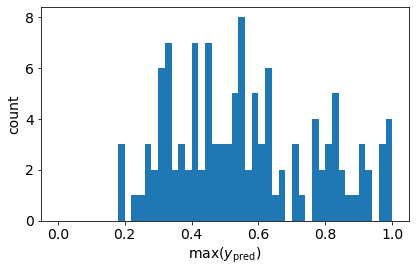

In [56]:
fig, ax = plt.subplots(1,1, figsize=(6,4), tight_layout=True)
ax.hist(ymax, bins=np.linspace(0,1,51))
ax.set(xlabel='$\max{(y_\mathrm{pred})}$',
       ylabel='count');
       #title='Tile {}, {}'.format(tile_id, obsdate));

### Selection on Classifier Output

To be conservative we can select only spectra where the classifier is very confident in its output, e.g., ymax > 0.99. See the [CNN training notebook](https://github.com/desihub/timedomain/blob/master/desitrip/docs/nb/cnn_multilabel-restframe.ipynb) for the motivation behind this cut.

In [57]:
idx = np.argwhere(ymax > 0.0) #0.99
labels = np.argmax(pred, axis=1)

In [58]:
idx.shape
label_names = ['Galaxy',
          'SN Ia',
          'SN Ib',
          'SN Ib/c',
          'SN Ic',
          'SN IIn',
          'SN IIL/P',
          'SN IIP',
          'KN']

In [59]:
# Randomly select 16 of the spectra and plot them.
#selection = sorted(np.random.choice(idx.flatten(), size=idx.shape[0], replace=False))
selection=idx
print(len(selection))

121


### GradCAM action happens here

Adapting from https://keras.io/examples/vision/grad_cam/

In [60]:
import tensorflow as tf
last_conv_layer_name = "conv1d_23"
classifier_layer_names = [
"batch_normalization_23",
"activation_23",
"max_pooling1d_23",
"flatten_5",
"dense_5",
"dropout_5",
"Output_Classes"
]

In [61]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        #print(layer_name,x.shape)
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    #print(grads.shape,pooled_grads.shape)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    #We apply ReLU here and select only elements>0
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

### Apply GradCAM to one spectrum only


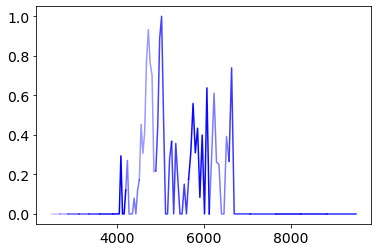

In [69]:
# Prepare image
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
#myarr=rsflux[:1,:] 
myarr=rsflux[selection[0],:] 

# Print what the top predicted class is
preds = classifier.predict(myarr)
#print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    myarr, classifier, last_conv_layer_name, classifier_layer_names
)


color='blue'
rewave_nbin_inblock=rewave.shape[0]/float(heatmap.shape[0])
first_bin=0
for i in range(1,heatmap.shape[0]+1):
    alpha=np.min([1,heatmap[i-1]+0.2])
    last_bin=int(i*rewave_nbin_inblock)
    plt.plot(rewave[first_bin:last_bin+1], myarr[0,first_bin:last_bin+1],c=color,alpha=alpha)
    first_bin=last_bin


### Apply GradCAM to all spectra classified as transients


In [128]:
#allzbest = allzbest[1:] #TEMP
#allzbest.pprint_all()
#print(labels.shape)
#print(labels)
#print(rewave.shape)
#print(rsflux.shape)

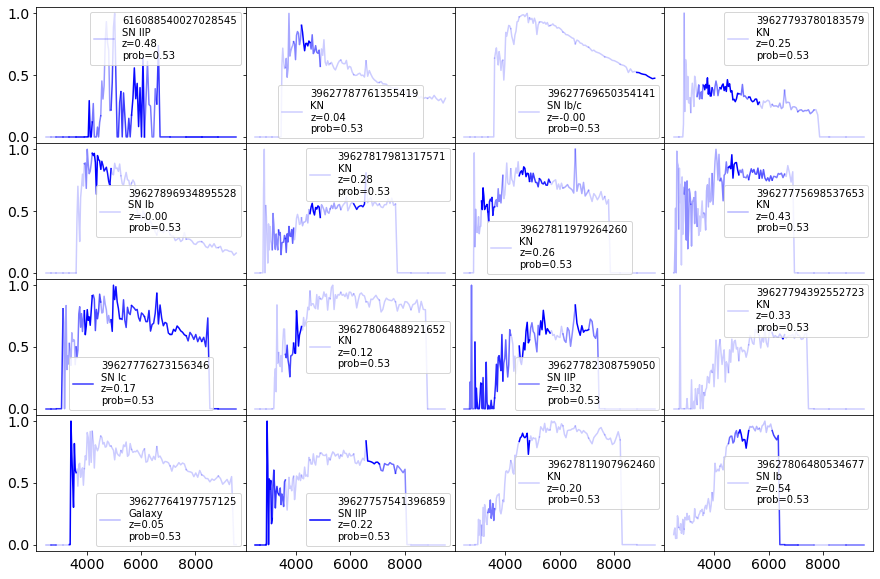

In [71]:
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

fig, axes = plt.subplots(4,4, figsize=(15,10), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0, 'hspace':0})

for j, ax in zip(selection[:16], axes.flatten()):
    myarr=rsflux[j,:] 
    #print()

    # Print what the top predicted class is
    preds = classifier.predict(myarr)
    #print("Predicted:", preds)

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(
        myarr, classifier, last_conv_layer_name, classifier_layer_names
    )

    color='blue'
    rewave_nbin_inblock=rewave.shape[0]/float(heatmap.shape[0])
    first_bin=0
    for i in range(1,heatmap.shape[0]+1):
        alpha=np.min([1,heatmap[i-1]+0.2])
        last_bin=int(i*rewave_nbin_inblock)
        if (i==1):
            ax.plot(rewave[first_bin:last_bin+1], myarr[0,first_bin:last_bin+1],c=color,alpha=alpha,\
                    label = str(allzbest[j[0]]['TARGETID']) + "\n" +
                    label_names[labels[j[0]]] + 
                    '\nz={:.2f}'.format(allzbest[j[0]]['Z']) +
                    '\nprob={:.2f}'.format(ymax[i]))
        else:
            ax.plot(rewave[first_bin:last_bin+1], myarr[0,first_bin:last_bin+1],c=color,alpha=alpha)
        first_bin=last_bin
    ax.legend(fontsize=10)

### Plot spectra of objects classified as transients
Plot observed spectra

In [63]:
testwave, testflux, testivar = rebin_flux(allwave, allflux, allivar,
                                    minwave=2500., maxwave=9500., nbins=150,
                                    log=True, clip=True)

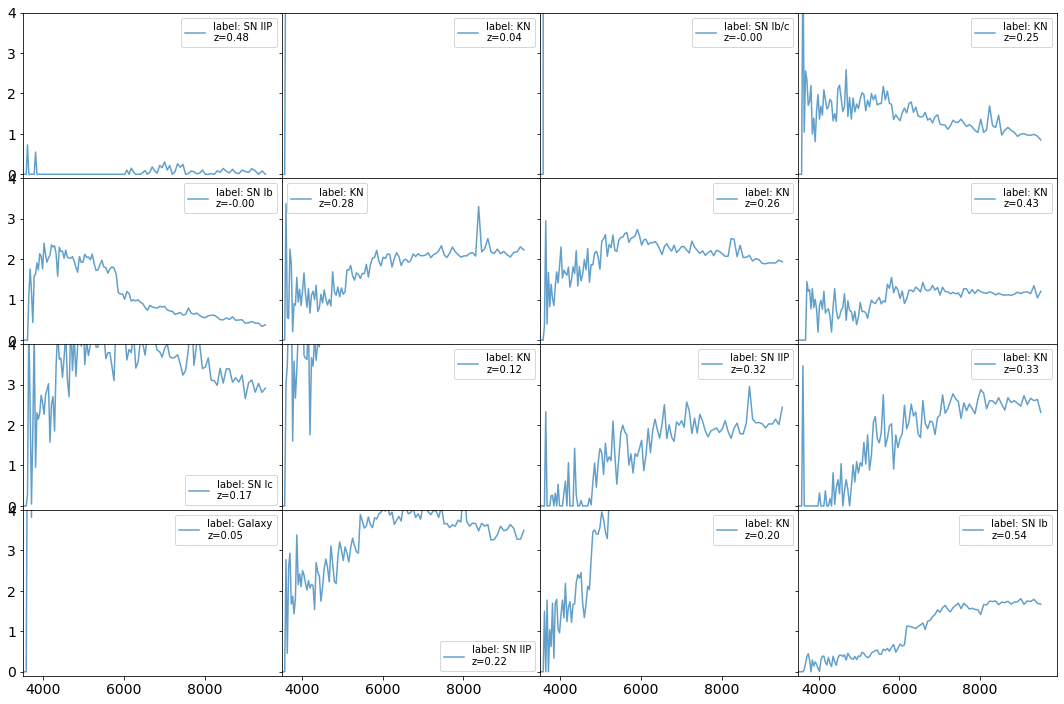

In [66]:
fig, axes = plt.subplots(4,4, figsize=(15,10), sharex=True, sharey=True,
                         gridspec_kw={'wspace':0, 'hspace':0})

for j, ax in zip(selection, axes.flatten()):
    ax.plot(testwave, testflux[j[0]], alpha=0.7, label='label: '+label_names[labels[j[0]]] +# Just this for single plot with [0] on testflux, label_names, allzbest
            '\nz={:.2f}'.format(allzbest[j[0]]['Z'])) # +
            #'\nobsdate={}'.format(obsdates[j[0]]) +
            #'\ntile id: {}'.format(tile_ids[j[0]]) +
            #'\npetal id: {}'.format(petal_ids[j[0]]))
    
    ax.set(xlim=(3500,9900),ylim=(-0.1,4))
    #ax.fill_between([5600,6000],[-0.1,-0.1],[4,4],alpha=0.1,color='blue')
    #ax.fill_between([7400,7800],[-0.1,-0.1],[4,4],alpha=0.1,color='blue')
    ax.legend(fontsize=10)
    
#for k in [0,1,2]:
#    axes[k,0].set(ylabel=r'flux [erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$]')
#    axes[2,k].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]', xlim=(3500,9900))
    
fig.tight_layout();
#filename = "spectra_plots/all_spectra_TAMU_ylim"
#plt.savefig(filename)

### For plotting individual plots

In [72]:
for j in selection:
    plt.plot(testwave, testflux[j[0]], alpha=0.7, label='label: '+ label_names[labels[j[0]]] + # Just this for single plot with [0] on testflux, label_names, allzbest
            #'\nz={:.2f}'.format(allzbest[j[0]]['Z']) +
            '\nprob={:.2f}'.format(ymax[i]))
            #'\nobsdate={}'.format(obsdates[j[0]]) +
            #'\ntile id: {}'.format(tile_ids[j[0]]) +
            #'\npetal id: {}'.format(petal_ids[j[0]]))
    
    plt.xlim(3500, 9900)
    #plt.ylim(-0.1, 50)
    #ax.fill_between([5600,6000],[-0.1,-0.1],[4,4],alpha=0.1,color='blue')
    #ax.fill_between([7400,7800],[-0.1,-0.1],[4,4],alpha=0.1,color='blue')
    plt.legend(fontsize=10)
    filename = "spectra_plots/"+"_".join(("TAMU", "spectra", str(allzbest[j[0]]['TARGETID']), str(obsdates[j[0]]), str(tile_ids[j[0]]), str(petal_ids[j[0]]), label_names[labels[j[0]]].replace(" ", "-").replace("/","-")))
    #filename = "spectra_plots/"+"_".join(("TAMU", "spectra", str(obsdates[j[0]+1]), str(tile_ids[j[0]+1]), str(petal_ids[j[0]+1]), label_names[labels[j[0]]].replace(" ", "-"))) # temp
    #plt.show();
    #print(filename)
    plt.savefig(filename)
    plt.clf()
    
#for k in [0,1,2]:
#    axes[k,0].set(ylabel=r'flux [erg s$^{-1}$ cm$^{-1}$ $\AA^{-1}$]')
#    axes[2,k].set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]', xlim=(3500,9900))
    
#fig.tight_layout();
#filename = "spectra_plots/all_spectra_TAMU_ylim"
#filename = "_".join(("spectra", str(obsdate), str(tile_id), label_names[labels[0]].replace(" ", "-")))
#plt.savefig(filename)

<Figure size 432x288 with 0 Axes>